# Working With Keras: Deep dive

Three different APIs for building models in Keras:
* Sequential Model: most approachable, basically a Python list. limited to simple stacks of layers
* Functional API: focuses on graph-like model architectures. Represents a nice mid-point between usability and flexibility, most commonly used model-building API.
* Model subclassing: low-level option where you write everything from scratch. Ideal if want full control over everything. However, won't get acess to many built-in Keras features, more error-prone.

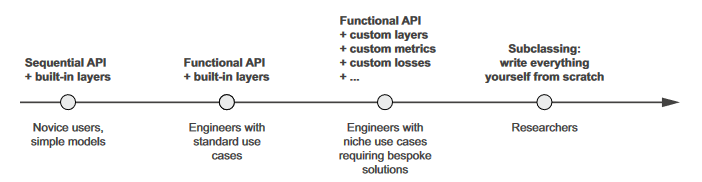

## The Sequential Model

Simplest way to build Keras model

In [1]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

Possible to build the same model incrementally using add()

In [2]:
model = keras.Sequential()
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

Layers only get built when are called the first time, this is because the shape of the layers' weights depends on the shape of their input: until the input shape is known, they can't be created.
The preceding Sequential model does not have any weights until you call it on some data, or call its build() method with an input shape

In [3]:
model.weights

ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [4]:
model.build((None,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


When building incrementally a Sequential model, it is useful to be able to print a summary of what the current model looks like after adding each layer. But you can't print a summary until the model is built!
There is a way to have the Sequential model built on the fly, just declare the shape of the model's inputs in advance, via the Input class.

In [5]:
model = keras.Sequential()
model.add(layers.Input(shape=(3,)))
model.add(layers.Dense(64,activation='relu'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.add(layers.Dense(10,activation='relu'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


Common debugging workflow when dealing with layers that transform inputs in complex ways, such as the convolutional layers.

## Functional API

Sequential model is easy to use but extremely limited, it can only express models with a single input and a single output, applying one layer after another.
In practice it's common to encounter model with multiple inputs, multiple outputs, or a nonlinear topology.
In such cases you'd build the model using the functional API. This is what most Keras models you'll encounter in the wild use.

In [7]:
inputs = keras.Input(shape=(3,), name='my_input')
features = layers.Dense(64,activation='relu')(inputs)
outputs = layers.Dense(10,activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

We started by declaring an Input:

inputs = kera.Input()

This input object holds info about the shape and dtype of the data the model will process

In [8]:
print(inputs.shape)
print(inputs.dtype)

(None, 3)
<dtype: 'float32'>


We call this object a symbolic tensor. It does not contain actual data, but it encodes the specifications of the actual tensors of data the model will see when you use it. It stand for future tensors of data.
Next, we created a layers and called it on the input:

features = layers.Dense()(inputs)

All Keras layers can be called both on real tensors and on symbolic tensors. In the latter case, tye return a new symbolic tensor, with updated shape and dtype

In [9]:
features.shape

TensorShape([None, 64])

After obtaining the final outputs, we instantiated the model by specifying its inputs and outputs in the Model constructor:

outputs = layers.Dense()(features)\
model = keras.Model()


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### Multi-Input and Multi-output Models
Most deep learning models don't look like lists, they look like graphs. For instance they may have multiple inputs or multiple outputs.
Let's say we buld a system to rank customer support tickets by priprity and route them to the appropriate department. Your model has three inputs:

* the title of the ticket (text input)
* the text body of the ticket (text input)
* the tags added by the user (categorical input)

We can encode the text inputs as arrays of ones and zeros of size vocabulary_size, the model will also have two outputs:

* the priority score of the ticket, scalar between 0 and 1 (sigmoid)
* the department that should handle the ticket (softmax)

In [11]:
vocabulary_size=10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name='title')
text_body = keras.Input(shape=(vocabulary_size, ), name="text_body")
tags = keras.Input(shape=(num_tags,), name='tags')

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation='relu')(features)

priority = layers.Dense(1, activation='sigmoid', name='priority')(features)
department = layers.Dense(num_departments, activation='softmax', name='department')(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority,department])

### Training multi-in multi-out model

You can train your model in much the same way you would train a Sequential one, by calling fit() with lists of input and output data. These lists of data should be in the same order as inputs passed in the Model constructor

In [12]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0,2, size=(num_samples,vocabulary_size))
text_body_data = np.random.randint(0,2, size=(num_samples,vocabulary_size))
tags_data = np.random.randint(0,2,size=(num_samples,num_tags))

priority_data = np.random.random(size=(num_samples,1))
department_data = np.random.randint(0,2,size=(num_samples,num_departments))

model.compile(optimizer='rmsprop',loss=['mean_squared_error','categorical_crossentropy'], metrics=[['mean_absolute_error'],['accuracy']])
model.fit([title_data,text_body_data,tags_data],[priority_data,department_data],epochs=1)
model.evaluate([title_data,text_body_data,tags_data],[priority_data,department_data])

40/40 [==============================] - 1s 6ms/step - loss: 19.8936 - priority_loss: 0.3376 - department_loss: 19.5560 - priority_mean_absolute_error: 0.5036 - department_accuracy: 0.1117


[19.89360237121582,
 0.33762291073799133,
 19.555978775024414,
 0.5035656094551086,
 0.11171875149011612]

If you don't want to rely on input order, you can also leverage the names given to the Input objects and the output layers, and pass the data via dictionaries

In [13]:
model.compile(optimizer="rmsprop",
    loss={"priority": "mean_squared_error", "department":
        "categorical_crossentropy"},
    metrics={"priority": ["mean_absolute_error"], "department":
        ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data,
    "tags": tags_data},
    {"priority": priority_data, "department": department_data},
    epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data,
    "tags": tags_data},
    {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 4ms/step


### Power of Functional API: Access to layer connectivity
Functional odel is an explicit graph data structure. this makes it possible to inspect how layers are connected and reuse previous graph nodes as part of new models. It also fits the mental model that most researchers use when thinking about a deep neural network: graph of layers.
This enables two important use cases: model visualization and feature extraction.
Let's visualize the connectivity of the model we defined. You can plot a functional model as a graph with the plot_model() utility

In [14]:
keras.utils.plot_model(model, 'ticket_classifier.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


You can add to this plot th einput and output shapes of each layer in the model, which can be hlpful during debugging

In [15]:
keras.utils.plot_model(model, 'ticket_classifier_with_shape_info.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


The "None" in the tensor shapes represents the batch size: this model allows batches of any size.
Access to layer connectivity also means that you can inspect and reuse individual nodes in the graph.
The model.layers model property provides the list of layers that make up the model, and for each layer you can query layer.input and layer.output

In [16]:
#Retireve ins and outs of a layer in functional model

print(model.layers)
print(model.layers[3].input)
print(model.layers[3].output)

[<keras.engine.input_layer.InputLayer object at 0x0000019E39BB90F0>, <keras.engine.input_layer.InputLayer object at 0x0000019E39BBB370>, <keras.engine.input_layer.InputLayer object at 0x0000019E39BB9450>, <keras.layers.merging.concatenate.Concatenate object at 0x0000019E39BD1030>, <keras.layers.core.dense.Dense object at 0x0000019E39BD1330>, <keras.layers.core.dense.Dense object at 0x0000019E39BD1930>, <keras.layers.core.dense.Dense object at 0x0000019E39BD2830>]
[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>, <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>, <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 20100), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


This enables to do feature extraction, creating models that reuse intermediate features from other models.

Let's say you want to add another output to the previous model, estimate how long a given issue ticket will take to resolve, a kind of difficult rating. You could do this via a classification layer over three categories: "quick", "medium" and "difficult".
You need to recreate and retrain a model from scratch. Start from the intermediate features of previous model, simce you have access to them.

In [17]:
#Create new model reusing intermediate layer outputs

features = model.layers[4].output
difficulty = layers.Dense(3,activation='softmax', name='difficulty')(features)

new_model = keras.Model(inputs=[title,text_body,tags],
                        outputs=[priority,department,difficulty])
keras.utils.plot_model(new_model)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Subclassing the Model Class
The last model-building pattern is the most advanced one:
Model Subclassing:
* In the __init__() method, define the layers the model will use.
* In the call() method, define the forward pass of the model, reusing the layers previously created.
* Instantiate your subclass, and call it on data to create its weights

In [18]:
#Prev example as subclassed model

class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation='relu')
        self.priority_scorer = layers.Dense(1, activation='sigmoid')
        self.department_classifier = layers.Dense(num_departments, activation='softmax')

    def call(self, inputs):
        title=inputs['title']
        text_body = inputs['text_body']
        tags = inputs['tags']

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

Once the model is defined, you can instantiate it. This will only create its weights the first time you call it on some data

In [19]:
model = CustomerTicketModel(num_departments=4)
priority, department = model({'title':title_data,'text_body':text_body_data,'tags':tags_data})

The difference between a Layer subclass and a Model subclass is simple, a layer is a building block used to create models, and a model is the top-level object you train, export fot inference, etc..
In shoer, Model has fit(), evaluate(), and predict() methods. Layers don't. 
Apart from this, the two classes are virtually identical. You can compile and train a Model subclass like Sequential and Functional

In [20]:
model.compile(optimizer='rmsprop', loss=['mean_squared_error','categorical_crossentropy'], metrics=[['mean_absolute_error'],['accuracy']])
model.evaluate({'title':title_data, 'text_body':text_body_data, 'tags':tags_data}, [priority_data,department_data])
priority_preds, department_preds = model.predict({'title':title_data, 'text_body':text_body_data, 'tags':tags_data})

40/40 [==============================] - 0s 4ms/step


#### What Subclass Model does not support

You are responsible for most of the model logic, which means potential error surface is much larger. As a result you have more debugging work to do. Functional and subclassed models are substantially different. A Functional model is an explicit data structure, a graph of layers which you can view, inspect, and modify. A subclassed model is a piece of bytecode - Python class with a call() method that contains raw code. this is the source of sublcassing workflow's flexibility, you can code up whatever functionality you like, but introduces new limitations.
For instance, because the way layers are connected to each other is hidden inside the body of the call()
method, you cannot access that info. Calling summary() will not display layer connectivity, and you cannot plot the model topology via plot_model(). Likewise, if you have a subclassed model, you cannot access the nodes of the graph of layers to do feature extraction because there is simply no graph. Once instantiated, the forward pass becomes a black box.

## Mix and match different patterns

Choosing one of these patterns does not lock you out of the others. All models in the Keras API can smoothly interoperate with each other. They are all part of the same spectrum of workflows.

In [21]:
#Create Functional model including subclassed model

class Classifier(keras.Model):

    def __init__(self,num_classes=2):
        super().__init__()
        if num_classes==2:
            num_units = 1
            activation='sigmoids'
        else:
            num_units=num_classes
            activation='softmax'
        self.dense = layers.Dense(num_units,activation=activation)

    def call(self,inputs):
        return self.dense(inputs)
    

inputs = keras.Input(shape=(3,))
features = layers.Dense(64,activation='relu')(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [22]:
#Subclassed mdodel including functional model

inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1,activation='sigmoid')(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self,num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation='relu')
        self.classifier = binary_classifier

    def call(self,inputs):
        features = self.dense(inputs)
        return self.classifier(features)
    
model = MyModel()


## Use Built-In training and evaluation loops
There are a couple of ways to customize the training workflow:

* Provide custom metrics
* Pass callbacks to fit() to schedule actions to be take at specific points during training

In [23]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28*28))
    features = layers.Dense(512,activation='relu')(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation='softmax')(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images,test_labels) = mnist.load_data()
images=images.reshape((60000, 28*28)).astype('float32')/255
test_images = test_images.reshape((10000, 28*28)).astype('float32')/255
train_images, val_images=images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images,train_labels,epochs=3,validation_data=(val_images,val_labels))
test_metrics = model.evaluate(test_images,test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2960 - accuracy: 0.9127 - val_loss: 0.1570 - val_accuracy: 0.9548
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1657 - accuracy: 0.9541 - val_loss: 0.1280 - val_accuracy: 0.9662
Epoch 3/3
313/313 [==============================] - 0s 1ms/step


### Write your own metrics
Metrics are key to measuring the performance of your model, commonly used metrics for classification and regression are already part of the built-in keras.metrics module. But, if you are doing anything out of the ordinary, you need to be able to write your own.
A Keras metric is a subclass of the keras.metrics.Metric class. Like layers, a metric has an internal state stored in TF variables. Unlike layers, these variables aren't updated via backpropagation, so you have to write the state-update logic which happens in the update_state() method.


In [26]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name='rmse', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name='mse_sum', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros', dtype='int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true-y_pred))
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    #Return current value of metric
    def result(self):
        return tf.sqrt(self.mse_sum/ tf.cast(self.total_samples,tf.float32))
    
    #You need to expose a way to reset the metric state without having to reinstantiate it
    #this enables the same metric objects to be used across different epochs of training or both training and evaluation
    def reset_state(self):
        self.mse_sum.assign(0,)
        self.total_samples.assing(0)

    
model = get_mnist_model()
model.compile(optimizer="rmsprop",
loss="sparse_categorical_crossentropy",
metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.9127 - rmse: 0.0000e+00

AttributeError: 'ResourceVariable' object has no attribute 'assing'

### Use callbacks

Launching a training run on a large dataset for tens of epochs usign model.fit() can be like launching a paper plane, past the initial inputlse you don't have control over it.
The Keras callbacks API help you transform a call to model.fit() from a paper airplan into a smart drone that can self-introspect and dynamically take action.
Callback is an object that is passed to the model in the call to fit() and that is called by the model at various points during training. It has access to all the available data avout the state of the model and its performance, and can take action: interrupt training, save a model, load a different weight set, or alter the state of the model.
Some examples are:

* Model checkpoint: save the current state of the model at different points of training
* Early stopping: interrupt training when the validation loss is no longer improving
* Dynamically adjust the value of certain parameters during training
* Logging training and validation metrics during training or visualizing the representations learned by the model as they are updated.



#### EarlyStopping and ModelCheckpoint
When training the model, there are many things you can't predict from the start. In particular you can't tell how many epochs will be needded to get to an optimal validation loss. A way to handle this is to stop training when you measure that the vaidation loss is no longer improving. This can be achieved using the EarlyStopping callback.
EarlyStopping interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs. Typically used in combination with ModelCheckpoint, which lets you continually save the model during training.

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                  keras.callbacks.ModelCheckpoint(filepath='checkpoint_path.keras'), monitor='val_loss',save_best_only=True]
model = get_mnist_model()
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_images,train_labels, epochs=10,callbacks=callbacks_list, validation_data=(val_images,val_labels))

### Write your own callbacks

If you need to take specific action during training that is not covered by one of the built-in callbacks, you can write your own. Callbacks are implemented by sub-classing the keras.callbacks.Callback class. You can implement any number of the following methods, which are called at various points during training:

on_epoch_begin(epoch, logs)
on_epoch_end(epoch, logs)
on_batch_begin(batch, logs)
on_batch_end(batch, logs)
on_train_begin(logs)
on_train_end(logs)

These methods are all called with a logs argument, which is a dictionary containing information about the previous batch, epoch, or training run - training and validation metrics and so on. The on_epoch_* and on_batch* methods also take the epoch and batch index as their first argument.

In [30]:
import matplotlib.pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses=[]

    def on_batch_end(self,batch,logs):
        self.per_batch_losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)),self.per_batch_losses, label='Training loss for each batch')
        plt.xlabel(f'Batch (epoch{epoch})')
        plt.ylabel(f'Loss')
        plt.legend()
        plt.savefig(f'plot_at_epoch_{epoch}')
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2997 - accuracy: 0.9117 - val_loss: 0.1554 - val_accuracy: 0.9567
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1665 - accuracy: 0.9528 - val_loss: 0.1281 - val_accuracy: 0.9659
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1396 - accuracy: 0.9626 - val_loss: 0.1280 - val_accuracy: 0.9681
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1245 - accuracy: 0.9668 - val_loss: 0.1294 - val_accuracy: 0.9703
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1206 - accuracy: 0.9701 - val_loss: 0.1082 - val_accuracy: 0.9755
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1131 - accuracy: 0.9726 - val_loss: 0.1119 - val_accuracy: 0.9747
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1049 - accuracy: 0.9748 - val_loss: 0.1249 - val_accuracy

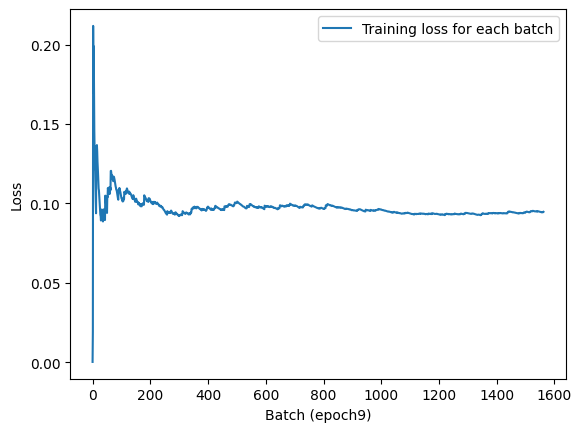

In [31]:
model = get_mnist_model()
model = get_mnist_model()
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_images,train_labels, epochs=10,callbacks=[LossHistory()], validation_data=(val_images,val_labels))

### Monitoring and Visualization with TensorBoard

To do good research or develop food models, you need rich, frequent feedback about what is foing on inside your models during your experiements. That's the point of running experiments. Making progress is an iterative process, a loop. You run this experiment and process the information it generates. This inspires your next idea. The more iterations of this loop you are able to run, the more refined and powerful your idea become.
What about processing the experiment's results? That's where TensorBoard comes in.
TensorBoard is a browser-based application that you can run locally.
It is the best way to monitor everything that goes on inside your model during training.
With TensorBoard, you can:

* Visually monitor metrics during training
* Visualize your model architecture
* Visualize histograms of activations and gradients
* Explore embeddings in 3D

Easiest way is to use it with Keras model and fit() method is to use the keras.callbacks.TensorBoard.

In [32]:
model = get_mnist_model()
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
tensorboard = keras.callbacks.TensorBoard(log_dir='./')
model.fit(train_images,train_labels, epochs=10,callbacks=[tensorboard], validation_data=(val_images,val_labels))

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2949 - accuracy: 0.9123 - val_loss: 0.1584 - val_accuracy: 0.9555
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1640 - accuracy: 0.9534 - val_loss: 0.1259 - val_accuracy: 0.9643
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1375 - accuracy: 0.9631 - val_loss: 0.1133 - val_accuracy: 0.9715
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1228 - accuracy: 0.9683 - val_loss: 0.1083 - val_accuracy: 0.9734
Epoch 5/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1142 - accuracy: 0.9708 - val_loss: 0.1076 - val_accuracy: 0.9761
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1105 - accuracy: 0.9734 - val_loss: 0.1135 - val_accuracy: 0.9763
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1037 - accuracy: 0.9750 - val_loss: 0.1138 - val_accuracy

Once the model starts running it will write logs at the target location. If you are running on a local machine, you can launch the local TensorBoard server using

tensorboard --logdir /full_path_to_log_dir

You can navigate to the URL the command returns to access the interface
I you are running on Colab, you can use the embedded TensorBoard instance as part of the notebook:

%load_ext tensorboard \
%tensorboard --logdir /full_path_to_log_dir

## Write your own training and evaluation loops

The fit() workflow has a nice balance between ease of use and flexibility. It is what you use most of the time. However, it is not meant to support everything a deep learning researcher may want to do, event with custom metrics, custom losses, and custom callbacks.
After all, fit() workflow is solely focused on supervised learning: setup where targets are known and are associated with the input data, and where you compute your loss as a function of these targets and the model's predictions. However, not every form of machine learning falls into this category. 
Whenever you find yourself in a situation where fit() is not enough, you need to write your own custom training logic.
The contents of a typical training loop look like this:

1. Run the forward pass (compute model's output) inside a gradient tape to obtain a loss value for the current batch of data.
2. Retrieve the gradient of the loss with regard to the model's weights
3. Update the model's weights so as to lower the loss value on the current batch of data.

These steps are repeated for as many batches as necessary. This essentially what fit() does under the hood.

### Training vs Inference
In the low-level training loop examples seen so far, step 1 was done via predictions = model(inputs), and step 2 was doen via gradients=tape.gradient(loss,model.weights). In the general case, there are actually two subtleties you need to take into account.
Some Keras layers, such as Dropout layer, have different behaviours during training and during ingerence. Such layers expose a training Boolean argument in their call() method. Calling dropout(inputs, training=True) will drop some activation entries, while calling dropout(inputs, training=False) does nothing. By extenson, Functional and Sequential models also expose this training argument in their call() methods. Pass training=True when calling Keras model during forward pass.
Our forward pass becomes thus predictions = model(inputs, training=True)
In addition, when you retrieve gradients of weights of your model you should not use tape.gradient(loss, model.weights), but rather tape.gradients(loss, model.trainable_weights). Indeed, layers, and models own two kinds of weights:
* Trainable weights - Meant to be updated via backpropagation to minimize the loss of the model, such as the kernel and bias of a Dense layer.
* Non-Trainable weights - Meant to be updated during the forward pass by the layers that own them. If you wanted a custom layer to keep a counter of how many batchs it has processed so far, that info would be stored in a non-trainable weight, and at each batch, your layer would increment counter by one.

Among Keras built-in layers, the only layer that features non-trainable weights is the BatchNormalization layer. It need non-trainable weights to track info about the mean and standard deviation of the data passing through, so to perform an online approximation of feature normalization.
Taking into account these two details, a supervised-learning training step ends up looking like:


In [ ]:
def train_step(inputs, targets):
    with tf.GradientTape as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets,predictions)
    gradients = tape.gradient(loss,model.trainable_weights)
    optimizer.apply_gradients(zip(model.trainable_weights,gradients))

### Low-level usage of metrics
In a low-level training loop, you want to leverage Keras metrics. Simply call update_state(y_true,y_pred) for each batch of targets and predictions, and then use result() to query the current metric value

In [37]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1,0,0],[0,1,0],[0,0,1]]
metric.update_state(targets,predictions)
current_result = metric.result()
print(f"result: {current_result}")

result: 1.0


You may want to also track the average of a scalar value, sucha as the model's loss.

In [38]:
values = [0,1,2,3,4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f'Mean of values: {mean_tracker.result():.2f}')

Mean of values: 2.00


Use metric.reset_state() to reset current results

### Complete training and evaluation loop

Let's combine forward pass, backward pass and metrics into a fit()-like training step function that takes a batch of data and targets and returns the logs that would get displayed by the fit() progress bar.

In [42]:
model = get_mnist_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs,training=True)
        loss = loss_fn(targets,predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    logs={}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()
    loss_tracking_metric.update_state(loss)
    logs['loss']=loss_tracking_metric.result()
    return logs

Need to reset the state of our metrics at the start of each epoch and before running evaluation.

In [43]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

We can now lay out our complete training loop. Note that we use a tf.data.Dataset object to turn our Numpy data into an iterator that iterates over the data in batchse of 32.

In [44]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels))
training_dataset = training_dataset.batch(32)
epochs=3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch,targets_batch)
    print(f'Results at the end of epoch {epoch}')
    for key, value in logs.items():
        print(f'...{key}: {value:.4f}')

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9143
...loss: 0.2905
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9539
...loss: 0.1635
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9622
...loss: 0.1387


Here's the evaluation loop: a simple for loop that repeatdly calls a test_step() function, which processes a single batch of data. The test_step() function is just a subset of the logic of train_step(). It omits the code that deal with updating the weights of the model, everything involving the GradientTape and optimizer.

In [46]:
def test_step(inputs,targets):
    predictions = model(inputs,training=False)
    loss = loss_fn(targets,predictions)

    logs={}
    for metric in metrics:
        metric.update_state(targets,predictions)
        logs['val_'+metric.name] = metric.result()
        loss_tracking_metric.update_state(loss)
        logs['val_loss'] = loss_tracking_metric.result()
        return logs
    
val_dataset = tf.data.Dataset.from_tensor_slices((val_images,val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch,targets_batch)
print('Evaluation results:')
for key, value in logs.items():
    print(f'...{key}:{value:.4f}')

Evaluation results:
...val_sparse_categorical_accuracy:0.9661
...val_loss:0.1287


### Make it fast with tf.function
You may have noticed that the custom loops are running slower than the built-in fit() and evaluate(), depite implementing essentially the same logic. That is because, by default, TensorFlow code is executed line by lije, eagerly, much like Numpy code or regular Python code. Eager execution makes it easier to debug your code, but it is far from ptimal from performance standpoint.
It is more performant to compile your TF code into a computation graph that can be globally optimized in a way that code intrpreted line by line cannot. the syntax to do this is very simple: just add @tf.function to any function you want to compile before executing.

In [47]:
@tf.function
def test_step(inputs,targets):
    predictions = model(inputs,training=False)
    loss = loss_fn(targets,predictions)

    logs={}
    for metric in metrics:
        metric.update_state(targets,predictions)
        logs['val_'+metric.name] = metric.result()
        loss_tracking_metric.update_state(loss)
        logs['val_loss'] = loss_tracking_metric.result()
        return logs
    
val_dataset = tf.data.Dataset.from_tensor_slices((val_images,val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch,targets_batch)
print('Evaluation results:')
for key, value in logs.items():
    print(f'...{key}:{value:.4f}')

Evaluation results:
...val_sparse_categorical_accuracy:0.9661
...val_loss:0.1287


Much Faster!
Remember, when you are debugging, prefer running eagerly, without @tf.function decorator. It is easier to track bugs this way. Once your code is working and you want to make it fast, add  a @tf.function decorator to your training step and evaluation step.

### Leveraging fit() with a custom training loop
What if you need a custom training algorithm, but you still want to leverage the power of built-in keras training logic?
You can provide a custom training step function and let the framework do the rest.
You can do this by overriding the training_step() method of the Model class. This is the function called fit() by every batch of data. You then are able to call fit() as usual, and it will be running your own learning algorith under the hood.
Here's some examples:
* Create new class subclassing keras.Model.
* Override train_step(self,data). Returns a dictionarymapping metric names to their current values
* Implement a metrics property that tracks the model's Metric instances. Enables the model to automatically call reset_state().

In [51]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name='loss')

class CustomModel(keras.Model):
    def train_step(self,data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets,predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients,model.trainable_weights))
        
        loss_tracker.update_state(loss)
        return{'loss': loss_tracker.result()}
    @property
    def metrics(self):
        return [loss_tracker]

In [52]:
inputs = keras.Input(shape=(28*28))
features = layers.Dense(512, activation='relu')(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation='softmax')(features)
model = CustomModel(inputs,outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images,train_labels,epochs=3)

Epoch 1/3
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2947
Epoch 2/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1670
Epoch 3/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1408


Couple of points to note:

* This pattern does not prevent building models with Functional API.
* Don't need to use a @tf.function decorator when overriding train_step

Now, what about metrics, and what about configuring the loss via compile()? After calling compile(), you get access to:

* self.compiled_loss - Loss function passed to compile()
* self.compliled_metrics - Wrapper for the list of metrics passed, which allows to call self.compiled_metrics.update_state() to update all of metrics at once.
* self.metrics - Actual list of metrics passed to compile(). It also includes a metric that tracks the loss.

In [53]:
class CustomModel(keras.Model):
    def train_step(self,data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets,predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients,model.trainable_weights))
        self.compiled_metrics.update_state(targets,predictions)
        return {m.name: m.result() for m in self.metrics}

In [55]:
inputs = keras.Input(shape=(28*28))
features = layers.Dense(512, activation='relu')(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation='softmax')(features)
model = CustomModel(inputs,outputs)

model.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images,train_labels,epochs=3)

Epoch 1/3
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2971 - sparse_categorical_accuracy: 0.9111
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.9542
Epoch 3/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1372 - sparse_categorical_accuracy: 0.9628
